In [129]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [3]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign

In [4]:
os.chdir("/mnt/c/Users/Maya/Dropbox/mek_results")

with open('Remkes_protein.p', 'rb') as f:
    all_ref = pickle.load(f)
with open('Remkes_protein_low.p', 'rb') as f:
    low = pickle.load(f)

all_ref['mek']['low-v2'] = low['mek']['low-v2']

mek = {}
for fraction in ['high', 'med']:
    mek[fraction] = Counter(all_ref['mek'][fraction])
mek['low-t'] = Counter(all_ref['mek']['low']) + Counter(all_ref['mek']['low-v2'])

### Examine the combined enrichment distributions

In [5]:
df_all = pd.DataFrame.from_dict(mek).fillna(0).sort_values(by=['high', 'med', 'low-t'], ascending=False)

In [6]:
df_all.describe()

,high,med,low-t
count,829144.000000,829144.000000,829144.000000
mean,5.738704,3.741781,8.380919
std,31.848957,9.404503,9.271202
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,6.000000
75%,0.000000,1.000000,13.000000
max,1185.000000,232.000000,453.000000


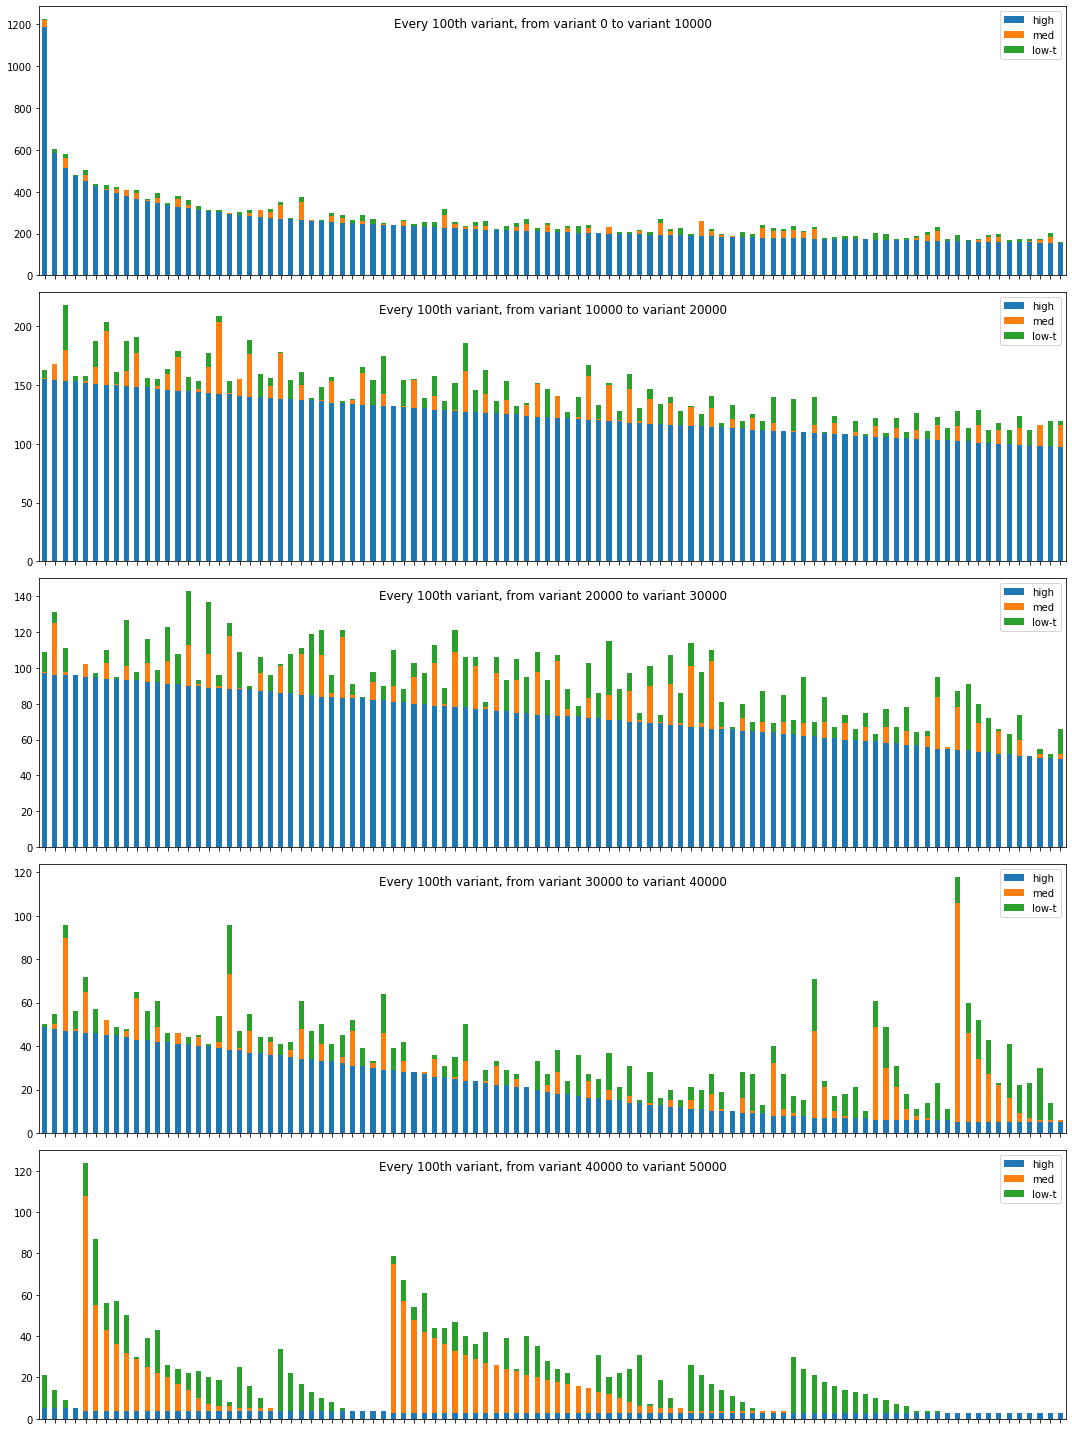

In [7]:
split = 10000
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_all.iloc[p*split:(p+1)*split:100].plot.bar(stacked=True, ax=axes[p])
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 100th variant, from variant ' + str(p*split) + ' to variant ' + str((p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()

plt.show()

The probability that a variant is truly 'active' decreases going down the plots, with a clear trend:
- the top 10K variants are 'active' with a high confidence, the appearance of variants in the medium and low gates is just experimental noise
- with some more variability, the same can be said for the next 10-20Ks variants, shown on the second plot. This covers variants with 100+ High reads
- looking at the last two plots, there is a high degree of variability in read distribution once we reach <20 reads in high gate. There, further investigation is needed. Two avenues: check the variants from 20K onwards at higher resolution to pin down the cutoff high gate count, and b) take the variants with fewer high counts below that and re-sort according to medium gate distribution. Especially in the less active variants that become the dominant factor.

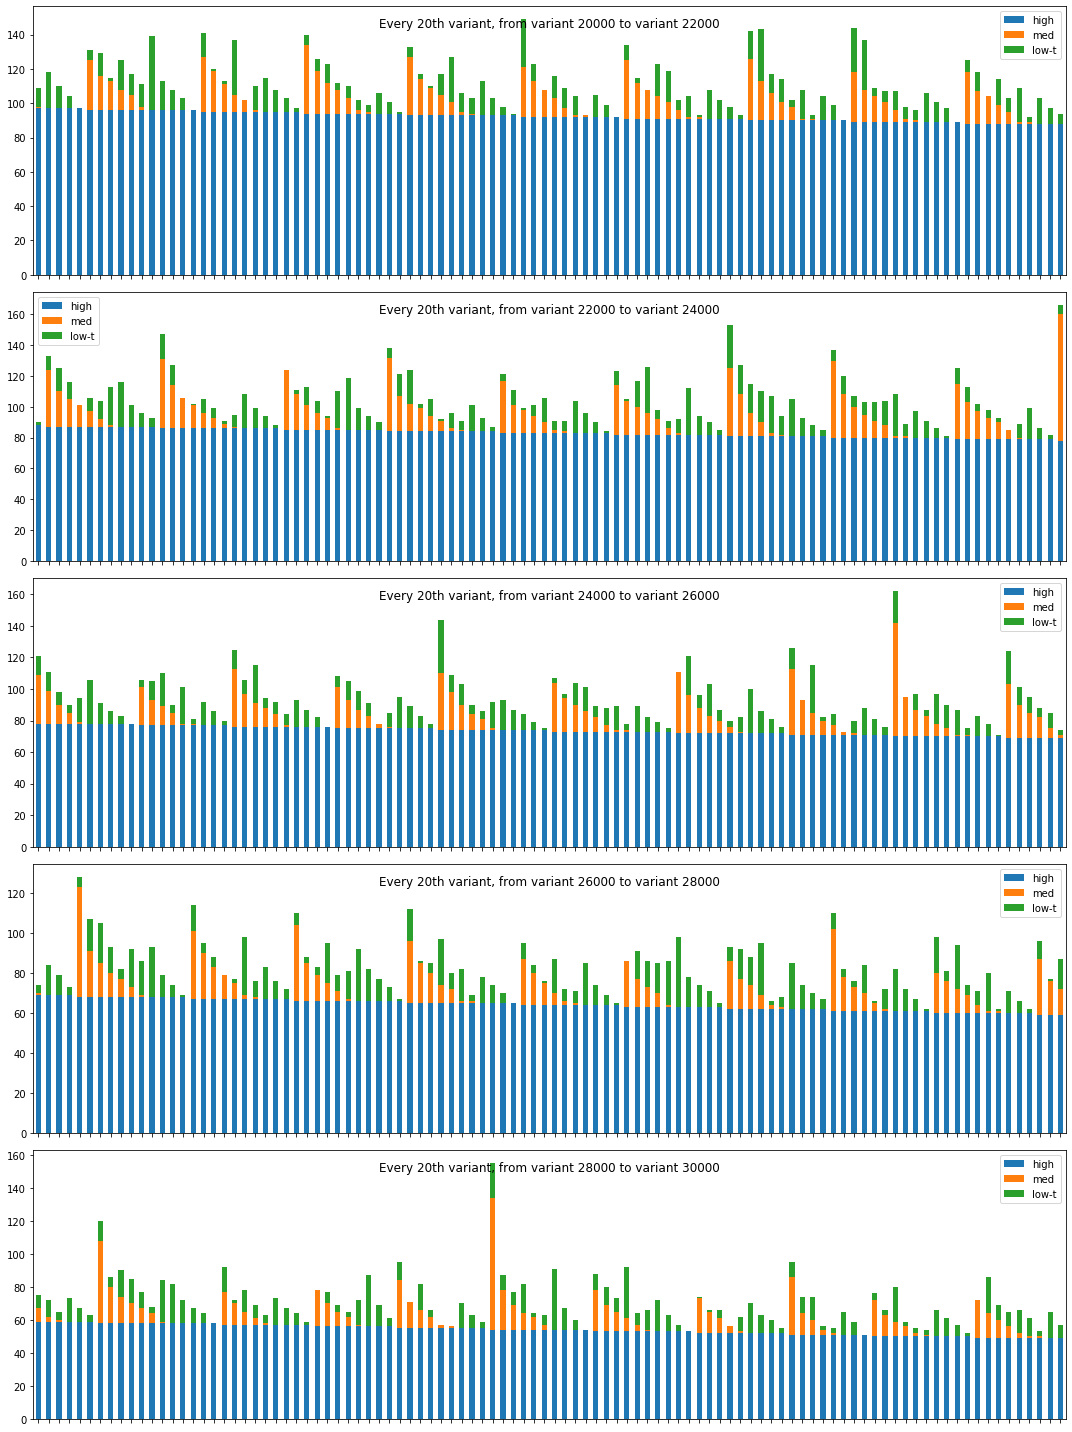

In [8]:
os = 20000
split = 2000
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_all.iloc[os+p*split:os+(p+1)*split:20].plot.bar(stacked=True, ax=axes[p])
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 20th variant, from variant ' + str(os+p*split) + ' to variant ' + str(os+(p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()

plt.show()

These plots show that from variant 20K to variant 30K there is increasing variation in the frequencies in medium and low gates. On the whole, the precise activity level for some of the variants is less clear-cut because some are equally or more frequent in the medium gate - are they 'active' and depleted from the sort? Or are they truly less active variants?

So, variants with 50+ reads in high gate are 'active'. Let's add some mild filtering to these variants, requiring that the low reads can be <20% of the combined medium + high reads.

In [9]:
df_50p = df_all.loc[(df_all['high'] >= 50) & ((df_all['high']+df_all['med']) > 2*df_all['low-t'])]
df_50p.describe()

,high,med,low-t
count,29725.000000,29725.000000,29725.000000
mean,145.750076,11.551724,11.230446
std,87.760870,15.494472,8.197057
min,50.000000,0.000000,0.000000
25%,86.000000,0.000000,5.000000
50%,123.000000,3.000000,10.000000
75%,177.000000,19.000000,16.000000
max,1185.000000,162.000000,69.000000


Then, let's try to stratify the distribution in variants below 50 reads in high gate.

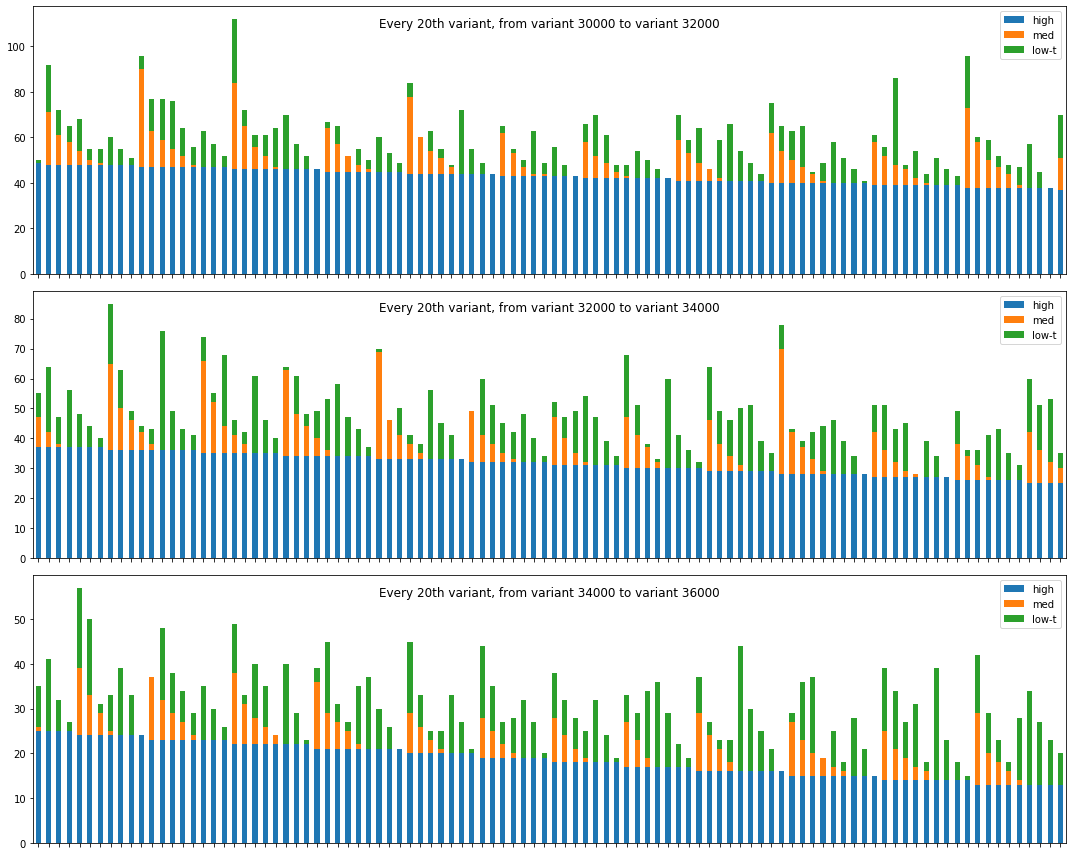

In [10]:
os = 30000
split = 2000
n=3

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_all.iloc[os+p*split:os+(p+1)*split:20].plot.bar(stacked=True, ax=axes[p])
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 20th variant, from variant ' + str(os+p*split) + ' to variant ' + str(os+(p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()

plt.show()

Below 30 reads in high gate, things are starting to look iffy. Still, there is a proportion of variants with reads only (or nearly only) in high gate.
- if the high gate is >10, accept as long as <20% of high+medium gate reads appear in the low gate, and # high gate > # medium gate.Remkes, how many reads in medium gate are okay?

So let's pick out those variants.

In [11]:
df_20to50 = df_all.loc[(df_all['high'].isin(range(10,50))) & 
                       (df_all['high'] > df_all['med']) & 
                       ((df_all['high']+df_all['med']) > 5*df_all['low-t']) ]

In [12]:
df_20to50.describe()

,high,med,low-t
count,2652.000000,2652.000000,2652.000000
mean,34.606335,6.297511,3.915158
std,10.655488,7.862844,2.905653
min,10.000000,0.000000,0.000000
25%,27.000000,0.000000,2.000000
50%,37.000000,3.000000,4.000000
75%,43.000000,10.000000,6.000000
max,49.000000,48.000000,18.000000


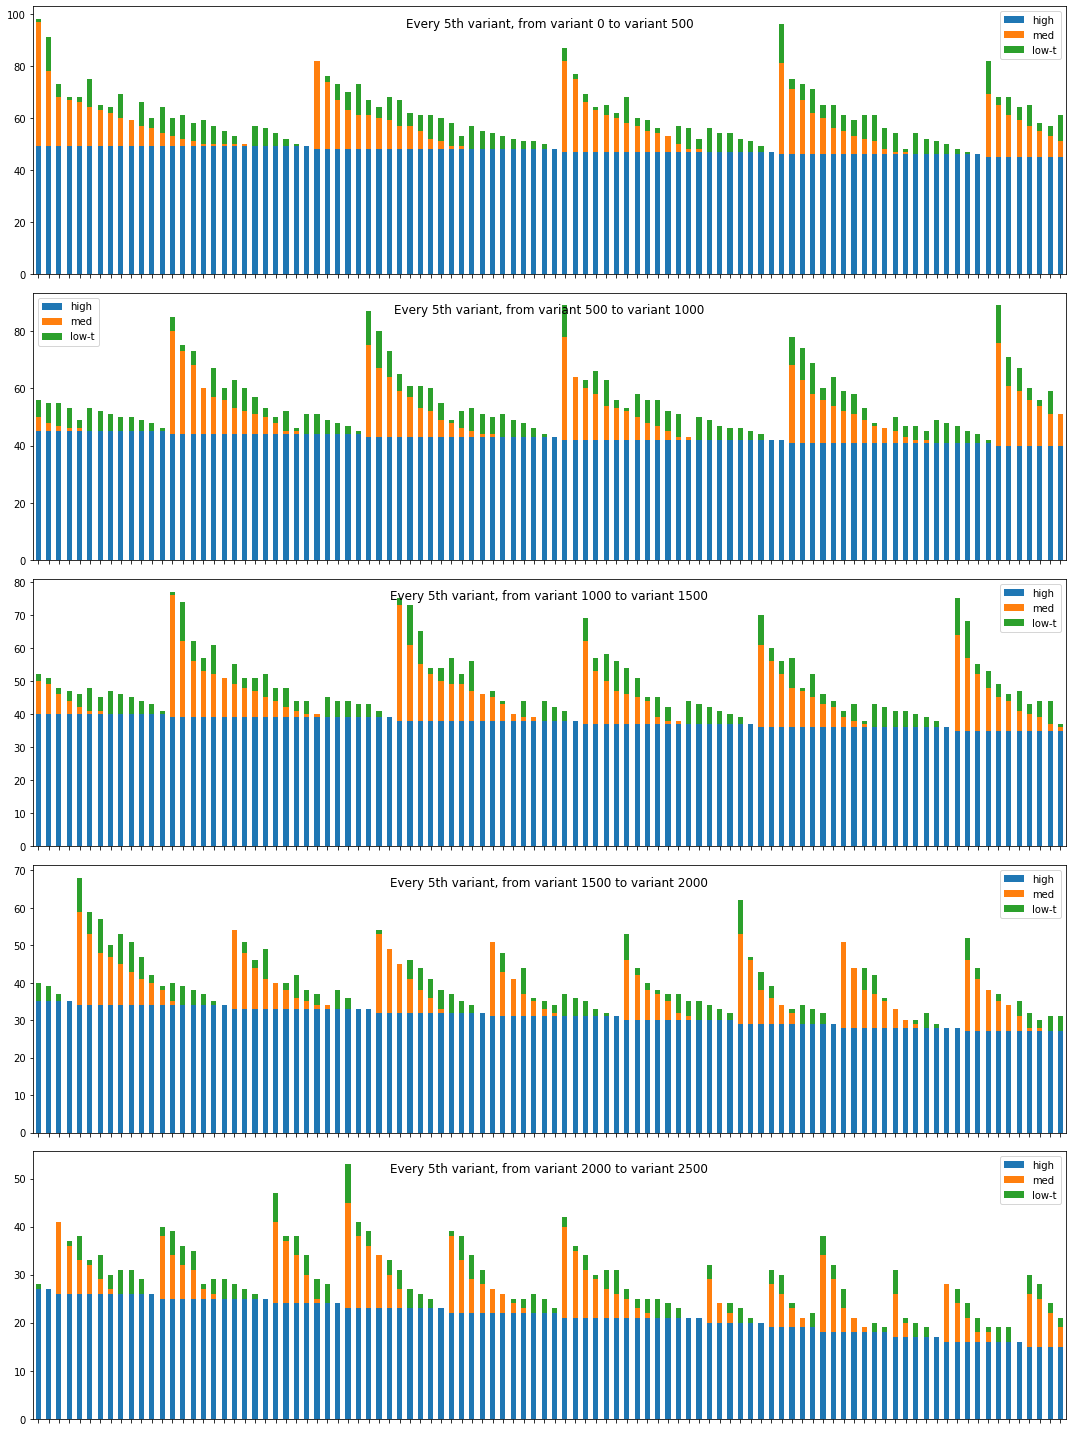

In [13]:
os = 0
split = 500
n=5

fig, axes = plt.subplots(n, 1,figsize=(15,4*n))

for p in range(len(axes)):
    df_20to50.iloc[os+p*split:os+(p+1)*split:5].plot.bar(stacked=True, ax=axes[p])
    
    axes[p].axes.get_xaxis().set_ticklabels([])
    title = 'Every 5th variant, from variant ' + str(os+p*split) + ' to variant ' + str(os+(p+1)*split)
    axes[p].set_title(title, position=(0.5, 0.9))


plt.tight_layout()

plt.show()

In [14]:
df_pos = df_50p.append(df_20to50)
pos = df_pos.to_dict()
pos.keys()

dict_keys(['high', 'med', 'low-t'])

In [15]:
from ipynb.fs.defs.Kinase_statistics import make_composition_plot_per_position, single_fraction_enrichment

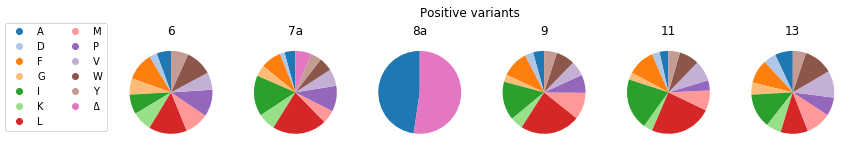

In [16]:
# Now use the distribution in this fraction to make plots
pos_enrich = single_fraction_enrichment(pos, 'high', 1, proportion=False)
df_pos_enrich = pd.DataFrame.from_dict(pos_enrich)
make_composition_plot_per_position(df_pos_enrich, 'Positive variants', 'Pos_with_filter')

In [17]:
df_pos.describe()

,high,med,low-t
count,32377.000000,32377.000000,32377.000000
mean,136.646292,11.121352,10.631251
std,89.495014,15.084813,8.148840
min,10.000000,0.000000,0.000000
25%,77.000000,0.000000,5.000000
50%,116.000000,3.000000,9.000000
75%,171.000000,18.000000,15.000000
max,1185.000000,162.000000,69.000000


### Generate arrays for 15 cross-position enrichments

In [18]:
from ipynb.fs.defs.Kinase_statistics import convert_variant_to_dict

In [146]:
# Set palette and the order of amino acids for meaningful colors
aa_order = ['A','G','P','Y','D','K','M','V','I','L','F','W','Δ']

aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
pos_aa = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

In [141]:
def two_position_enrichment(input, proportion=True):
    """
    input: a Counter 
    posA, posB: two positions between which to generate a heatmap
    """
    valid_pos = ['6', '7a', '8a', '9', '11', '13']
    
    counts = {
        posA : {
            aaA : {
                posB : {
                    aaB: 0 for aaB in pos_aa[posB]}
                for posB in valid_pos}
            for aaA in pos_aa[posA]}
        for posA in valid_pos}

    for mutation_string, count in input.items():
         # m_by_pos[position] = AA
        m_by_pos = convert_variant_to_dict(mutation_string)
        # check the mutations is one we're interested in
        observed_aa = set(m_by_pos.values())
        if not observed_aa.issubset(aa_13):
            continue
                
        if proportion:
            c = count
        else:
            c = 1
                
        # here this becomes similar as for single enrichments, except we need to loop twice
        for posA, aaA in m_by_pos.items():
            for posB, aaB in m_by_pos.items():
                counts[posA][aaA][posB][aaB] += c

    return counts

In [147]:
cross_e = two_position_enrichment(pos['high'])

In [148]:
cross_dfs = {posA : {posB : "" for posB in valid_pos} for posA in valid_pos}

for posA in valid_pos:
    for posB in valid_pos:
        dict_data = {aaA : [cross_e[posA][aaA][posB][aaB] for aaB in pos_aa[posB]] for aaA in pos_aa[posA]}
        cross_dfs[posA][posB] = pd.DataFrame.from_dict(dict_data, orient='index', columns=pos_aa[posB])

In [149]:
log_dfs = {}

for posA in valid_pos:
    log_dfs[posA] = {}
    for posB in valid_pos:
        total = cross_dfs[posA][posB].sum().sum()
        cells = len(pos_aa[posA]) * len(pos_aa[posB])
        avg_cnt = total/cells
        log_dfs[posA][posB] = (cross_dfs[posA][posB]/avg_cnt).apply(np.log10)      

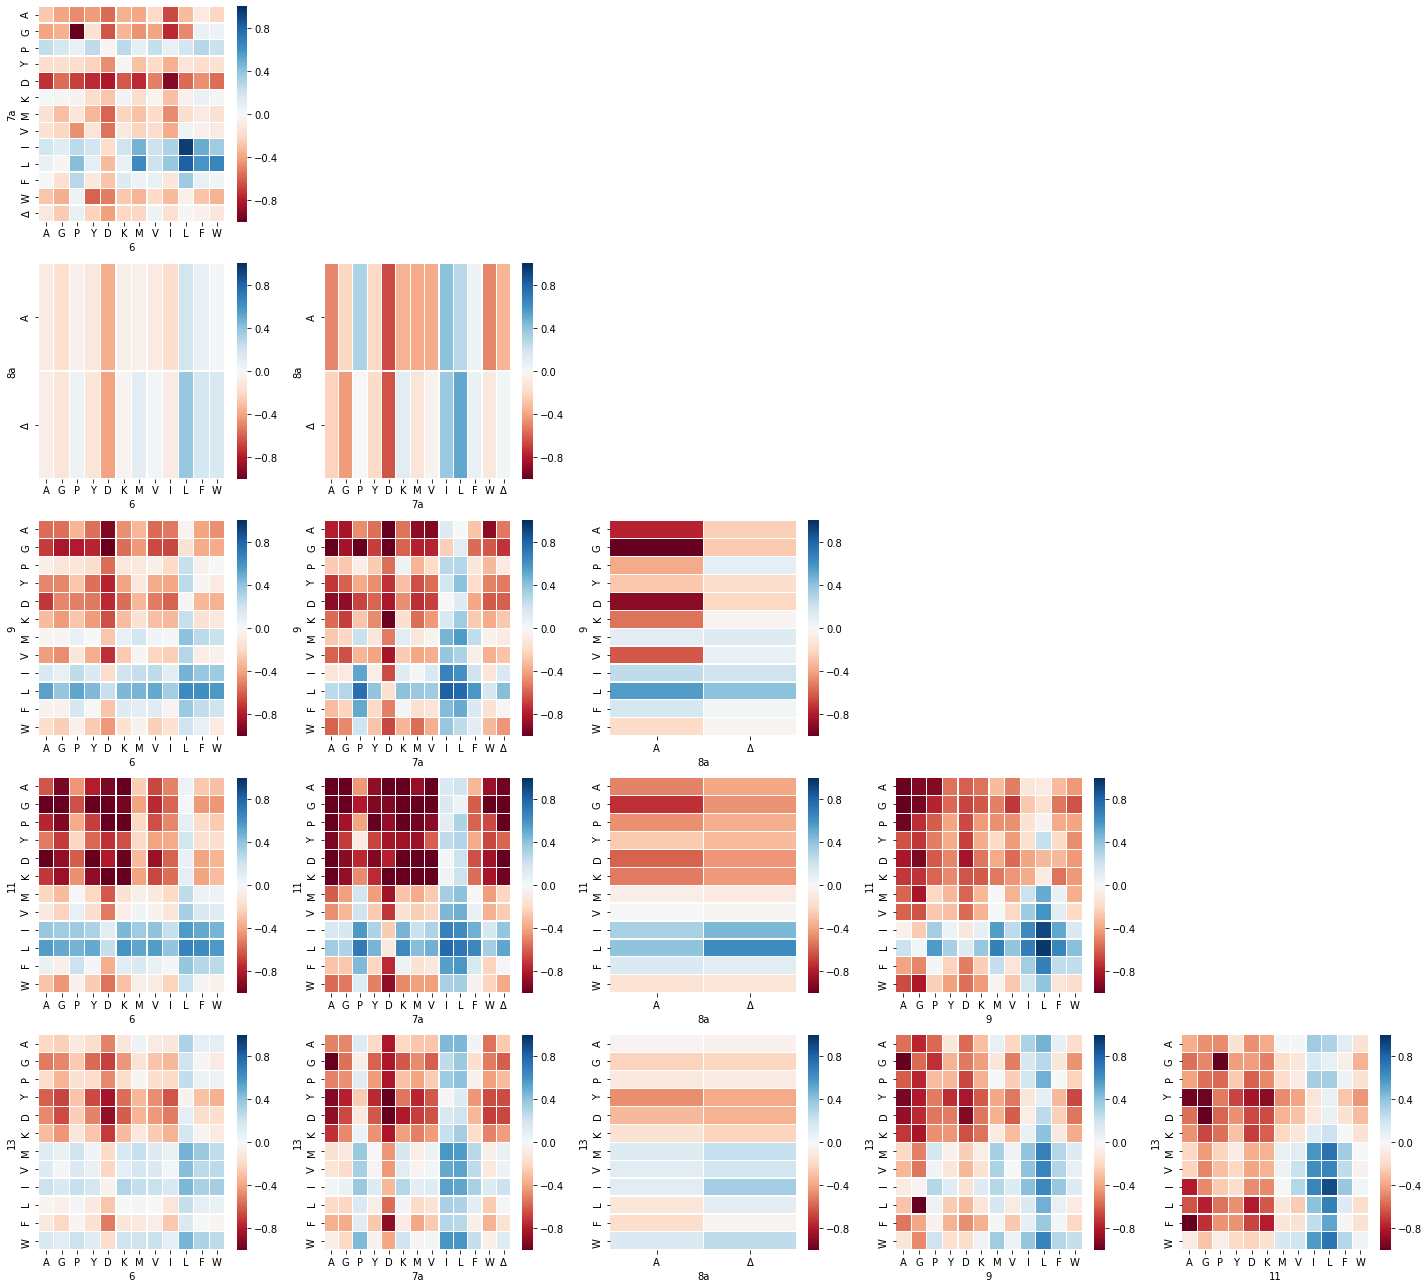

In [152]:
fig, axes = plt.subplots(5, 5, figsize=(20,18))

# top left axes = axes[0,0]
# top row, middle = axes[0,2]

for a in range(len(valid_pos)): # a = row index, running from 0 to 4
    for b in range(len(valid_pos)): # b = column index, running from 0 to 4
        if (b == 5) or (a == 0):
            continue
        elif b >= a:
            axes[a-1][b].axis('off')
            continue
        else:
            sns.heatmap(log_dfs[valid_pos[a]][valid_pos[b]], vmin=-1, vmax=1, linewidths=0.2, ax=axes[a-1][b], cmap="RdBu")
            axes[a-1][b].set_xlabel(valid_pos[b])
            axes[a-1][b].set_ylabel(valid_pos[a])

plt.tight_layout()
plt.savefig('2D_heatmaps_unrestricted.svg')
plt.show()